# F-tune sampling

- we control the number of times the sample was seen

- additionally we are not considering prefix duplicates. The prefix deduplication was done for being able to do not have false negatives. Which means that for the same prefix we have different suffixes but in our sample set might be the case that we are not having that exact suffix (one of many for a single prefix) and we erroneously classify a sample as non memorized when actually it is.

In [ ]:
import torch 
from datasets import load_dataset
from transformers import AutoTokenizer

# parallel processing
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)
from tqdm import tqdm
tqdm.pandas()

# utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [2]:
from collections import Counter

In [3]:
# the random seed
seed = 42

#length of the tokenizer truncation
max_length = 1024

#n.samples to be extracted from the final filtered samples
n_samples = 1000

In [5]:
# Load the tokenizer from HF-hub
checkpoint = "bigcode/starcoder2-3b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the sequences
# keep in mind of truncation 
# in this case avoid padding! Since we don't want to sample place holders!
#def tokenize_input_ptrain(batch):
    #return tokenizer(batch['content'], return_tensors='pt')
#    return tokenizer(batch['content'], truncation = True, max_length=4096, padding = 'do_not_pad',  return_tensors='pt')

def tokenize_input_ftune(batch):
    #return tokenizer(batch['content'], return_tensors='pt')
    return tokenizer(batch['content'], truncation = True, max_length= max_length, padding = 'do_not_pad',  return_tensors='pt')

# Create the fine-tune samples for the attack

In [6]:
# load the data
dataset = dataset = load_dataset("parquet", data_files={'train': '../train_java.parquet'})

In [7]:
# remove non-necessery columns form the sample filtering
dataset = dataset.remove_columns(['input_ids', 'attention_mask', 'n_tok', 'longline', 'alpha', 'encoded', 'autogen'])

In [9]:
# apply the tokenizer
dataset = dataset.map(tokenize_input_ftune, batched=False, num_proc=64)

# convert it to a pandas dataframe
df = dataset['train'].to_pandas()
# I don't know why but after the tokenization I have a list of lists and I want to get rid of that
df['input_ids'] = df['input_ids'].apply(lambda x: x[0])

# filter out the input with a number of tokens > 300
df['n_tok'] = df['input_ids'].apply(len)
df = df[df['n_tok'] > 300 ]

# save a copy for later
df_query = df.copy()

In [ ]:
df_query['sample'] = df_query['input_ids'].progress_apply(lambda x: [x[i:i+300] for i in range(0, len(x)-299)])
df_query = df_query.explode('sample') # explode the list of lists
df_query['hash'] = df_query['sample'].progress_apply(lambda x: hash(tuple(x)))

# count the hashes (to retrieve the one uniques)
hashes_ptrain = Counter(df_query['hash'])

In [44]:
dup_dist = df_query.groupby(by='hash')['hash'].count()

# Distribution plot

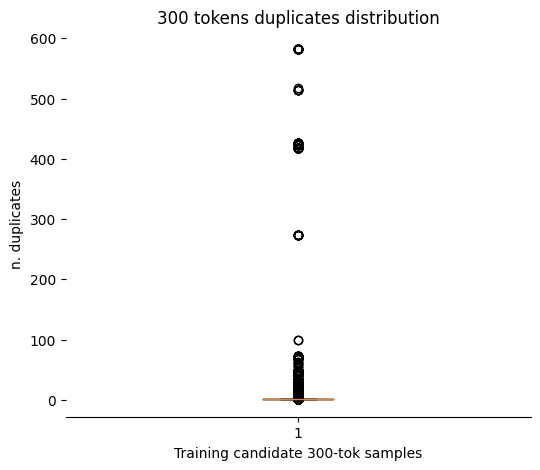

In [50]:
fig, ax = plt.subplots(figsize=(6, 5))
bplot = ax.boxplot(dup_dist)

# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.set_title('300 tokens duplicates distribution')
ax.set_xlabel('Training candidate 300-tok samples')
ax.set_ylabel('n. duplicates')

plt.show()
fig.savefig('./train_dist_dedup.pdf', format='pdf')